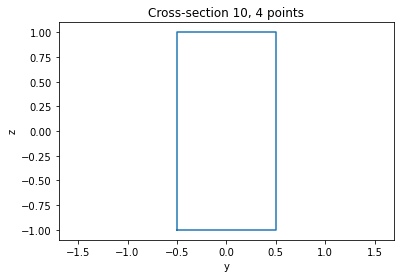

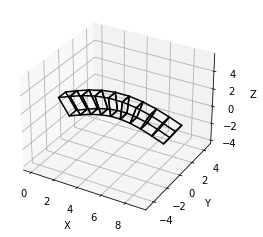

In [27]:
# -*- coding: utf-8 -*-
"""
Created on Sun Apr 17 09:14:17 2022

@author: naraz
"""

import numpy as np
import scipy
from scipy.spatial.transform import Rotation as R
from scipy.spatial.transform import Slerp
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

class CrossSection:
    # define cross section in the local coordinate system
    # x is the direction perpendicular to the cross-section
    # cross-sections are defined in yz plane
    def __init__(self):
        self.C = None
        self.yz = None
        
    def Rectangule(self,b,h):
        yz = np.zeros((4,2))
        yz[:,0] = np.array([-0.5*b,0.5*b,0.5*b,-0.5*b])
        yz[:,1] = np.array([-0.5*h,-0.5*h,0.5*h,0.5*h])
        self.yz = yz
        self.AddCurrentSection()
        return yz
        
    def AddCurrentSection(self):
        yz = self.yz.reshape((1,self.yz.shape[0],self.yz.shape[1])) #shape: 0-row 1-column #reshape: change to yz plane 1代表1面
        if self.C is None: #注意写法
            self.C = yz
        else:
            self.C = np.concatenate((self.C,yz),0) #concatenate: 矩阵叠加. 这里是在x轴上重复 (0-x 1-y 2-z) 代表一个面叠加为一个矩阵
        return self.C #所有面都重叠在一起

    def Show(self):
        idx = np.mod(np.arange(self.yz.shape[0]+1),self.yz.shape[0]) #这里的yz没有被reshape  #np.arange(1,10,3): 从1开始，到9结束，中间隔3 (默认从0开始中间隔1) #np.mod(x,y): 算x/y所得余数
        plt.figure()
        plt.plot(self.yz[idx,0],self.yz[idx,1]) #idx的作用: 0坐标-1坐标-2坐标-3坐标-0坐标 #####################好！！！
        plt.xlabel('y'); plt.ylabel('z')
        plt.axis('equal')
        plt.title("Cross-section {:d}, {:d} points".format(self.C.shape[0],self.C.shape[1]))


class Member:
    def __init__(self,C,t=None,quat=None): #C是一个截面内所有点为一个小矩阵的三维矩阵 C[0]是第几个面 C[1],C[2]代表坐标
        # t: translation of the cross-sections
        # quat: rotation (quaternion) of the cross-sections
        self.n = C.shape[0] #number of faces
        self.npts = C.shape[1] #number of vertices in one face
        if t is None:
            t = np.zeros((self.n,3)) #np.array(a,b): a行b列
            t[:,0] = np.arange(self.n) #第一列: 0--(self.n-1) #只要在x轴上转制，先埋好伏笔
        self.t= t
        
        if quat is None:
            quat = np.zeros((self.n,4)) #np.array(a,b): a行b列
            quat[:,3] = 1. #quaternion is (x,y,z,w) #总共self.n个四元数
        self.R = R.from_quat(quat)   #把四元数转化为旋转矩阵
        
        self.v = [] #vertices
        self.f = [] #faces
        
        xyz = np.zeros((self.npts,3)) #对之前C里的每个面进行处理, xyz只代表一个面
        for i in range(self.n):
            xyz[:,1:] = C[i,:,:] #xyz所有行,第二列开始到最后一列 x坐标全是0 #这里对C的处理是把每一个面提取出来 
            c = self.R[i].apply(xyz) + self.t[np.zeros(self.npts,dtype=int)+i,:] #self.R[i]: 第i个旋转矩阵 #先旋转，再移动  #self.t这里的写法是把第i行全矩阵重复
            self.v = self.v + [(c[k,0],c[k,1],c[k,2]) for k in range(self.npts)]  #(c[k,0],c[k,1],c[k,2]) is a list. 
            if i>0:
                m = self.npts * (i-1)
                idx1 = np.arange(m,m+self.npts)    #blender counts from 0
                idx2 = np.arange(m+self.npts,m+2*self.npts) 
                self.f = self.f + [(idx1[k],idx1[np.mod(k+1,self.npts)],idx2[np.mod(k+1,self.npts)],idx2[k]) for k in range(self.npts)] #这是在x方向上的连接！！！ 通过一个面相邻两点和下个面对应相邻两点连成小长方形
        
    def Show(self):
        v = np.array(self.v)
        plt.figure()
        ax = plt.axes(projection='3d')
        for f in self.f:
            idxv = np.array(f)
            ax.plot3D(v[idxv,0], v[idxv,1], v[idxv,2], 'k')
            
        vmin = v.min(0); vmax = v.max(0); ctr = (vmin+vmax)/2.  #min(0) is the minimum of every column, min(1) is the minimum of every row min() is the minimum of all number #这里是找到中间面
        half = (vmax-vmin).max()/2.
        ax.set_xlim((ctr[0]-half,ctr[0]+half))
        ax.set_ylim((ctr[1]-half,ctr[1]+half))
        ax.set_zlim((ctr[2]-half,ctr[2]+half)) #合适的显示区域
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
if __name__ == "__main__":
    cs = CrossSection()
    n = 10
    # create constant rectangular cross section
    for i in range(n):
        cs.Rectangule(1.0, 2.0)
    cs.Show()
    
    # define arbitrary cross-sectional translation and rotation
    t = np.zeros((n,3)); t[:,0] = np.arange(n); 
    a = 1.5; omega = np.pi / (n-1)
    t[:,2] = np.sin(omega*np.arange(n)) * a #上升下降在一个弧度上
    ##t[:,2] =np.arange(n)
    rotvec = np.zeros((n,3))
    rotvec[:,1] = -np.arctan(omega * a * np.cos(omega*np.arange(n))) #????
    ##rotvec[:,2] = np.arange(n)
    Rot = R.from_rotvec(rotvec) #注意函数, y轴变动为绕y转
    
    m = Member(cs.C,t,Rot.as_quat())
    #print(m.v)
    #print(m.f)
    m.Show()
   